In [1]:
abstract type Kernel end

Base.length(k::Kernel) = Base.length(fieldnames(typeof(k)))


function cov(k::Kernel, xs1, xs2)
    # covariance matrix
    n1 = size(xs1, 1)
    n2 = size(xs2, 1)
    c = zeros(n1, n2)
    for i in 1:n1
        for j in 1:n2
            c[i, j] = ker(k, xs1[i, :], xs2[j, :])
        end
    end
    c
end

cov(k::Kernel, xs) = cov(k, xs, xs)

cov (generic function with 2 methods)

In [2]:
"""
Gaussian Kernel
"""
mutable struct GaussianKernel <: Kernel
     theta::Float64
end

function ker(k::GaussianKernel, x1, x2)
    exp(- sum((x1 - x2).^2) / k.theta)
end

function logderiv(k::GaussianKernel, x1, x2)
    [ker(k, x1, x2) / k.theta * sum((x1 - x2).^2)]
end

function update!(k::GaussianKernel, theta)
    k.theta = Float64(theta)
    k
end

update! (generic function with 1 method)

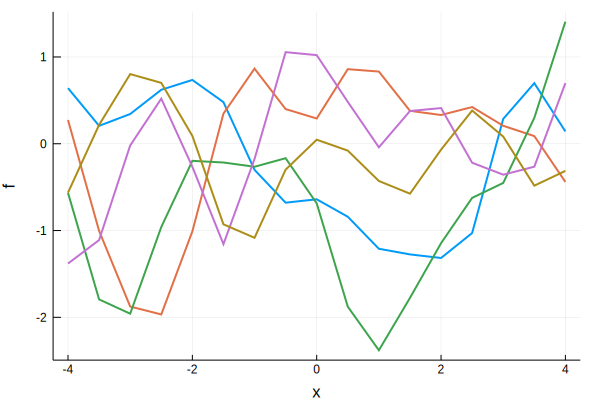

In [3]:
using Distributions
using Plots

gk = GaussianKernel(1)
xs = collect(-4:0.5:4)
gk_dist = MvNormal(zeros(Base.length(xs)), cov(gk, xs))
Plots.plot(xs, rand(gk_dist, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

In [4]:
xs = collect(-4:0.1:4)
gk_dist = MvNormal(zeros(Base.length(xs)), cov(gk, xs))
Plots.plot(xs, rand(gk_dist, 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

LinearAlgebra.PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [5]:
using LinearAlgebra

"""
Gaussian Process
"""
mutable struct GaussianProcess{K <: Kernel}
    kernel::K
    eta::Float64 # regularization parameter
    GaussianProcess(kernel::K) where {K <: Kernel} = new{K}(kernel, 1e-6)
    GaussianProcess(kernel::K, eta::Real) where {K <: Kernel} = new{K}(kernel, Float64(eta))
end

function cov(gp::GaussianProcess, xs)
    # regularlize
    n = size(xs, 1)
    cov(gp.kernel, xs) + gp.eta * Matrix{Float64}(I, n, n) 
end

function dist(gp::GaussianProcess, xs)
    l = size(xs, 1)
    k = cov(gp, xs)
    MvNormal(zeros(l), k)
end

Base.length(gp::GaussianProcess) = Base.length(gp.kernel) + 1

function update!(gp::GaussianProcess, params...)
    update!(gp.kernel, params[1:end - 1]...)
    gp.eta = params[end]
    gp
end

update! (generic function with 2 methods)

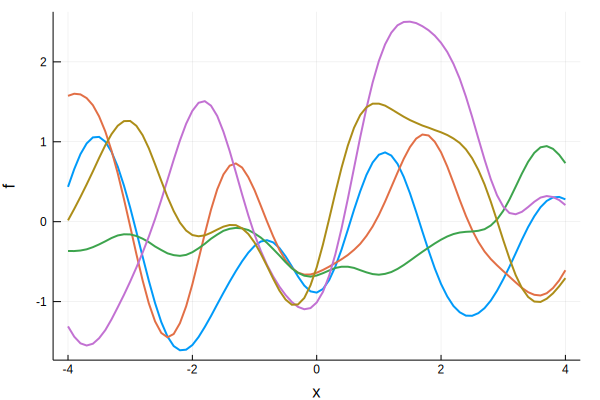

In [6]:
# Gaussian Kernel
gp = GaussianProcess(GaussianKernel(1))
xs = collect(-4:0.1:4)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

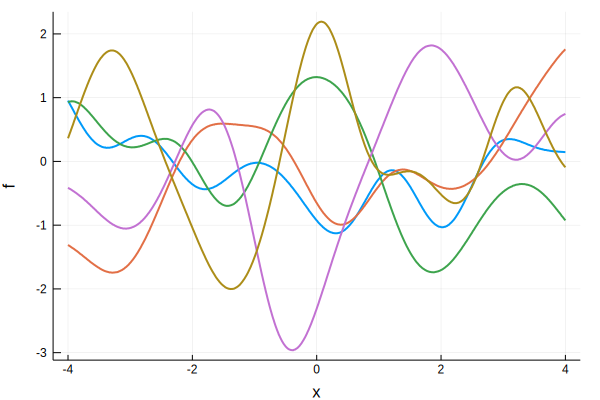

In [7]:
xs = collect(-4:0.01:4)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

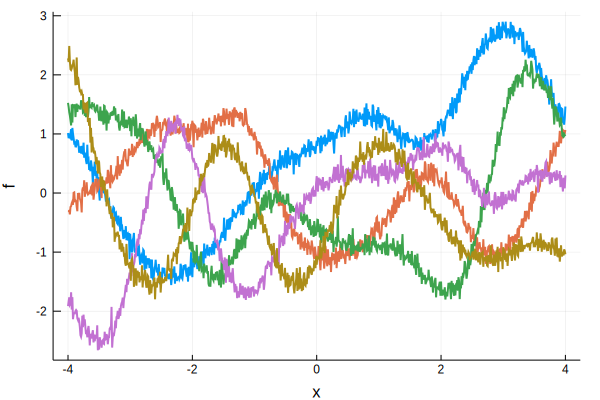

In [8]:
# Gaussian Kernel + Noise
gp = GaussianProcess(GaussianKernel(1), 0.01)
xs = collect(-4:0.01:4)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

In [9]:
"""
Constant kernel
"""
struct ConstantKernel <: Kernel end

function ker(k::ConstantKernel, x1, x2)
    return 1.0
end

function logderiv(k::ConstantKernel, x1, x2)
    []
end

update!(k::ConstantKernel) = k

"""
Linear kernel
"""
struct LinearKernel <: Kernel end

function ker(k::LinearKernel, x1, x2)
    return 1.0 + dot(x1, x2)
end

function logderiv(k::LinearKernel, x1, x2)
    []
end

update!(k::LinearKernel) = k

update! (generic function with 4 methods)

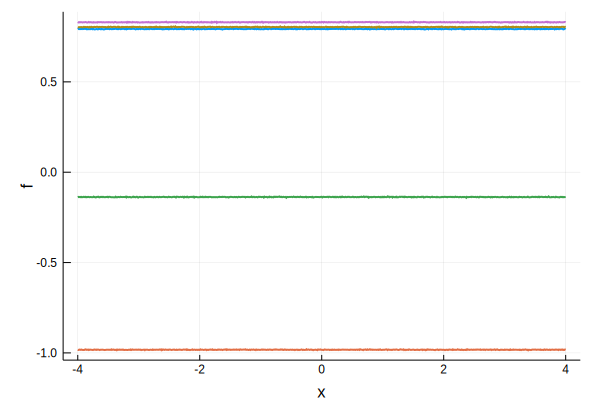

In [10]:
# ConstantKernel

gp = GaussianProcess(ConstantKernel())
xs = collect(-4:0.01:4)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

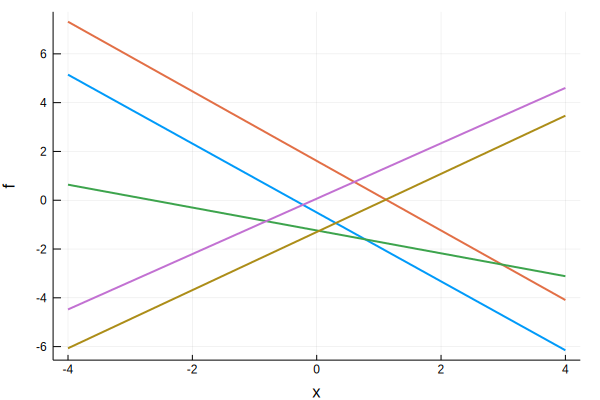

In [11]:
# LinearKernel

gp = GaussianProcess(LinearKernel())
xs = collect(-4:0.01:4)
Plots.plot(xs, rand(dist(gp, xs), 5), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

In [12]:
import Base: +, *

"""
Scalar product
"""
mutable struct KernelScalarProd <: Kernel
    coef::Float64
    kernel::Kernel
end

function ker(k::KernelScalarProd, x1, x2)
     k.coef * ker(k.kernel, x1, x2)
end

function logderiv(k::KernelScalarProd, x1, x2)
    [ker(k.kernel, x1, x2), 
     k.coef * logderiv(k.kernel, x1, x2)...]
end

Base.length(k::KernelScalarProd) = 1 + Base.length(k.kernel)

function update!(k::KernelScalarProd, params...)
    k.coef = params[1]
    update!(k.kernel, params[2:end]...)
    k
end

"""
Sum
"""
mutable struct KernelSum <: Kernel
    kernel1::Kernel
    kernel2::Kernel
end

function ker(k::KernelSum, x1, x2)
     ker(k.kernel1, x1, x2) + ker(k.kernel2, x1, x2)
end

function logderiv(k::KernelSum, x1, x2)
    [logderiv(k.kernel1, x1, x2)..., 
     logderiv(k.kernel2, x1, x2)...]
end

Base.length(k::KernelSum) = Base.length(k.kernel1) + Base.length(k.kernel2)

function update!(k::KernelSum, params...)
    l = Base.length(k.kernel1)
    update!(k.kernel1, params[1:l]...)
    update!(k.kernel2, params[l+1:end]...)
    k
end

*(coef::Real, k::Kernel) = KernelScalarProd(Float64(coef), k)
+(k1::Kernel, k2::Kernel) = KernelSum(k1, k2)

+ (generic function with 207 methods)

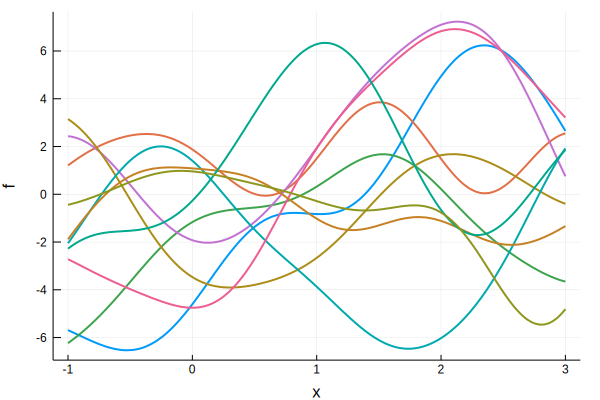

In [13]:
gp = GaussianProcess(10 * GaussianKernel(1))
xs = collect(-1:0.01:3)
Plots.plot(xs, rand(dist(gp, xs), 10), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

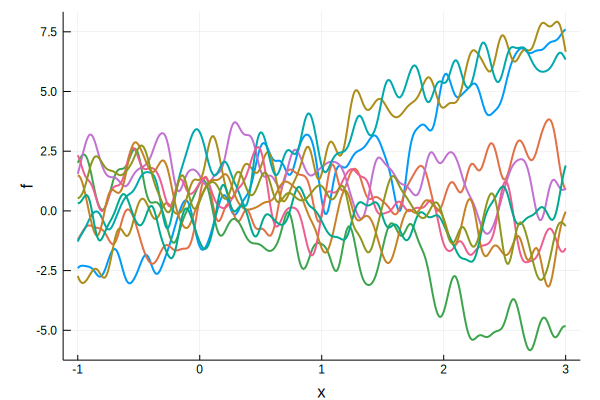

In [14]:
gp = GaussianProcess(2.0 * LinearKernel() 
    + 0.8 * GaussianKernel(0.01))
xs = collect(-1:0.01:3)
Plots.plot(xs, rand(dist(gp, xs), 10), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

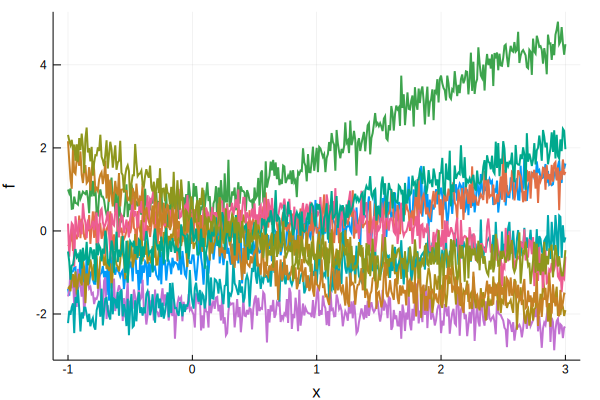

In [15]:
gp = GaussianProcess(1.596 * GaussianKernel(6.560), 0.082)
xs = collect(-1:0.01:3)
Plots.plot(xs, rand(dist(gp, xs), 10), 
    label = "", xlabel = "x", ylabel = "f",
    linewidth = 2,
    title = "")

In [16]:
function predict(gp::GaussianProcess, xtest, xtrain, ytrain)
    k_star = cov(gp.kernel, xtrain, xtest)
    s = cov(gp, xtest)

    k_inv = inv(cov(gp, xtrain))
    k_star_inv = k_star' * k_inv
    mu = k_star_inv * ytrain
    sig = s - k_star_inv * k_star
    sig = Symmetric(s - k_star_inv * k_star)
    MvNormal(mu, sig)
end

predict (generic function with 1 method)

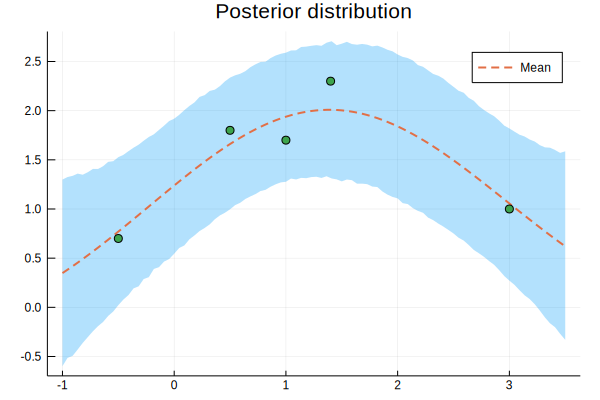

In [17]:
xs = [-0.5, 0.5, 1, 1.4, 3]
ys = [0.7, 1.8, 1.7, 2.3, 1]

gp = GaussianProcess(1.596 * GaussianKernel(6.560), 0.082)

xtest = collect(range(-1, stop=3.5, length=100))
pred = predict(gp, xtest, xs, ys)
qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

Plots.plot(xtest, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
    label = "", linewidth = 0)
Plots.plot!(xtest, mean(pred), label = "Mean", linewidth = 2, linestyle = :dash)

scatter!(xs, ys, label = "", title = "Posterior distribution")

In [18]:
function logp(gp::GaussianProcess, xs, ys)
    k = cov(gp, xs)
    k_inv = inv(k)
    -log(det(k)) - ys' * k_inv * ys
end

function fg!(gp::GaussianProcess, xs, ys, F, G, params)
    # -logp and gradient
    y = exp.(params)
    update!(gp, y...)
    k = cov(gp, xs)
    k_inv = inv(k)
    k_inv_y = k_inv * ys

    n = size(xs, 1)

    function deriv(d_mat::Matrix{<: Real})
        -(-tr(k_inv * d_mat) + k_inv_y' * d_mat * k_inv_y)
    end

    # gradient
    if G != nothing
        d_tensor = zeros(n, n, Base.length(gp))
        for i in 1:n
            for j in 1:n
                t = logderiv(gp.kernel, xs[i, :], xs[j, :])
                d_tensor[i, j, 1:end - 1] = t
            end
        end
        d_tensor[:, :, end] = y[end] .* Matrix{Float64}(I, n, n) # eta
        G .= mapslices(deriv, d_tensor, dims = [1, 2])[:]
    end

    # log likelihoood
    if F != nothing
        return -(-log(det(k)) - ys' * k_inv * ys)
    end
end

fg! (generic function with 1 method)

In [19]:
gp = GaussianProcess(1.0 * GaussianKernel(1.0), 1.0)

GaussianProcess{KernelScalarProd}(KernelScalarProd(1.0, GaussianKernel(1.0)), 1.0)

In [20]:
using Optim

lower = fill(-30.0, 3)
upper = fill(30.0, 3)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp, xs, ys, F, G, x)),
    lower, upper, [0.0, 0.0, 0.0], 
    Fminbox(GradientDescent()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.4677728528438338,1.8810363129622452, ...]
 * Minimum: 1.738770e+00
 * Iterations: 3
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 6.21e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 9.45e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 9.23e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 353
 * Gradient Calls: 353
[theta1, theta2, theta3] = [1.59643, 6.5603, 0.0819847]


In [21]:
logp(gp, xs, ys)

-1.7387703743398042

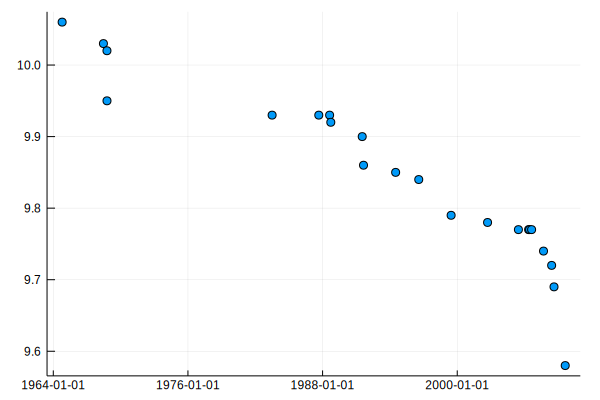

In [22]:
using CSV
using Dates
using DataFrames

df = CSV.read(IOBuffer(
"Date,Time
1964/10/15,10.06
1968/6/20,10.03
1968/10/13,10.02
1968/10/14,9.95
1983/7/3,9.93
1987/8/30,9.93
1988/8/17,9.93
1988/9/24,9.92
1991/7/14,9.9
1991/8/25,9.86
1994/7/6,9.85
1996/7/27,9.84
1999/6/16,9.79
2002/9/14,9.78
2005/6/14,9.77
2006/5/12,9.77
2006/6/11,9.77
2006/8/18,9.77
2007/9/9,9.74
2008/5/31,9.72
2008/8/16,9.69
2009/8/16,9.58"); dateformat="yyyy/mm/dd")
disallowmissing!(df)
scatter(df.Date, df.Time, label="")

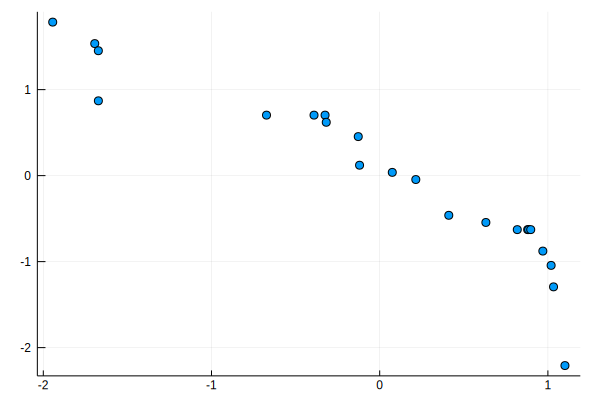

In [23]:
xs_raw = Dates.value.(df.Date .- Date(0, 1, 1)) ./ 365
xs_mean, xs_std = mean(xs_raw), std(xs_raw)
ys_raw = df.Time
ys_mean, ys_std = mean(ys_raw), std(ys_raw)

xs = (xs_raw .- xs_mean) ./ xs_std
ys = (ys_raw .- ys_mean) ./ ys_std

scatter(xs, ys, label="")

In [24]:
function plot_gp_100m(gp, pars)

    update!(gp, exp.(pars)...)
    x_test = collect(range(-2, stop=2, length=100))
    pred = predict(gp, x_test, xs, ys)
    qt = mapslices(x -> quantile(x, [0.025, 0.975]), rand(pred, 10000), dims = 2)

    # convert
    x_test = x_test .* xs_std .+ xs_mean
    qt = qt .* ys_std .+ ys_mean
    Plots.plot(x_test, qt[:, 1], fillrange = qt[:, 2], fillalpha = 0.3,
        label = "", linewidth = 0)
    Plots.plot!(x_test, mean(pred) .* ys_std .+ ys_mean, label = "", linewidth = 2, linestyle = :dash)
    scatter!(xs_raw, ys_raw, label = "")
end

plot_gp_100m (generic function with 1 method)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [1.4404906589345008,2.6294999978819886, ...]
 * Minimum: -1.486413e+01
 * Iterations: 20
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 5.07e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 7536
 * Gradient Calls: 7536
[theta1, theta2, theta3] = [4.22277, 13.8668, 0.102625]
logp:14.864131619224107


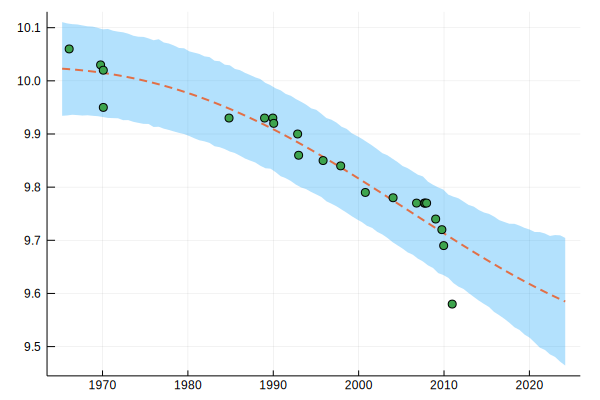

In [25]:
gp = GaussianProcess(1.0 * GaussianKernel(1.0), 1.0)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, 0.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp, xs, ys))

plot_gp_100m(gp, pars)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,-3.0]
 * Minimizer: [0.4403584574143354,-1.4741097963164387, ...]
 * Minimum: -1.407396e+01
 * Iterations: 5
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.45e-08 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 331
 * Gradient Calls: 331
[theta1, theta2, theta3] = [1.55326, 0.228982, 0.0429989]
logp:14.073964533876048


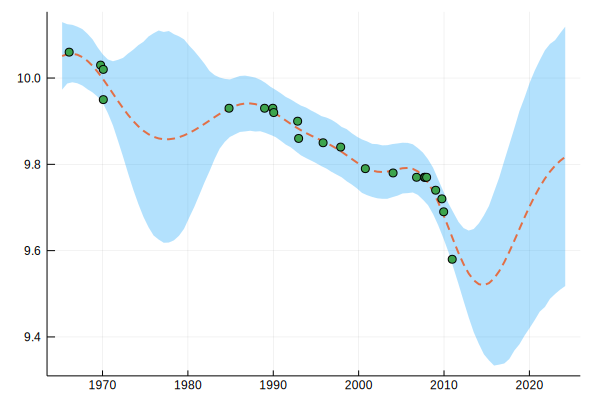

In [26]:
res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp, xs, ys, F, G, x)),
    fill(-10.0, 3), fill(10.0, 3), [0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3] = ", exp.(pars))
println("logp:", logp(gp, xs, ys))

plot_gp_100m(gp, pars)

Results of Optimization Algorithm
 * Algorithm: Fminbox with L-BFGS
 * Starting Point: [0.0,0.0,0.0,0.0,-3.0]
 * Minimizer: [-3.591175043240611,-0.6634886622587809, ...]
 * Minimum: -1.970913e+01
 * Iterations: 12
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.18e+00 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 4960
 * Gradient Calls: 4960
[theta1, theta2, theta3, theta4, theta5] = [0.0275659, 0.515051, 0.110337, 0.0252142, 0.0470559]
logp:19.709131389510937


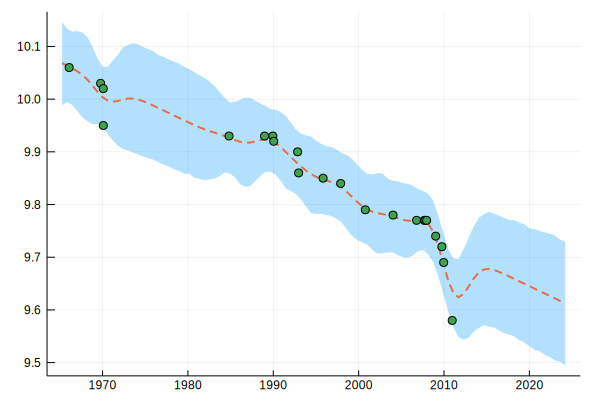

In [27]:
gp_2 = GaussianProcess(1.0 * ConstantKernel() + 1.0 * LinearKernel() + 1.0 * GaussianKernel(1.0), 1.0)

res = optimize(
    Optim.only_fg!((F, G, x) -> fg!(gp_2, xs, ys, F, G, x)),
    fill(-10.0, 5), fill(10.0, 5), [0.0, 0.0, 0.0, 0.0, -3.0], 
    Fminbox(LBFGS()))

println(res)
pars = Optim.minimizer(res)
println("[theta1, theta2, theta3, theta4, theta5] = ", exp.(pars))
println("logp:", logp(gp_2, xs, ys))

plot_gp_100m(gp_2, pars)